In [1]:
import numpy as np
import pylab as p
from scipy import integrate

In [2]:
# Helper functions

def double_time_to_percent_change(timesteps):
    ''' Convert cycle count to double a population to percent increase per generation. '''
    assert timesteps > 0
    percent_increase = 2 ** (1/timesteps) - 1
    return percent_increase

def percent_change_to_rate(percent_change):
    ''' Convert a generational percent change to a rate. '''
    assert 0 <= percent_change
    rate = np.log(1+percent_change)
    return rate   

def find_inflection_point(X):
    ''' Find generation where Exposed population is most prevelant. '''
    population_argmax = list(map(np.argmax, X))
    inflection_point = np.NAN
    if 2 in population_argmax:
        inflection_point = population_argmax.index(2)    
    return inflection_point

In [3]:
# Differential Equations

def dX_dt(X, t=0):
    ''' ODEs. '''    
    I_i, S_i, E_i = X
    N = sum(X) if include_carrying_capacity else 0           # incorporate carrying capacity

    return np.array([
        (B*I_i)*(1 - N/K) - (alpha*I_i),                     # d/dt(I)
        (B*S_i)*(1 - N/K) - (C*S_i*I_i) - (S_i*mu),          # d/dt(S)
        (C*S_i*I_i) + (B*E_i)*(1 - N/K) - (alpha*E_i)        # d/dt(E)
    ])

In [4]:
# Parameters

# Carrying capacity
include_carrying_capacity = True
K= 1e20                                                                             # carrying capacity 1e15, 1e30

# Parameters (rates)
B = percent_change_to_rate(double_time_to_percent_change(timesteps=1))              # birth rate as determined by desired cycle count
C = percent_change_to_rate(1e-7)                                                    # conjugation rate
mu = percent_change_to_rate(0.027)                                                  # death rate (succeptible)
alpha = percent_change_to_rate(0.1)                                                 # death rate (infected)        # 0.25, 0.28

# Initial populations
I_0 = 100                                                                           # infected (infected, conjugative donor)    # minimum 3
S_0 = 1e10                                                                          # sucecptible
E_0 = 0                                                                             # exposed (infected, not donor)
X0 = np.array([I_0, S_0, E_0])                                                      # Initial ISE populations

# Timesteps: 
#   timestep = 1 generation = 20 min = doubling time
t = np.arange(0, 25, 1)       # 8 hours, 24 timesteps

In [5]:
# Run model
X, infodict = integrate.odeint(dX_dt, X0, t, full_output=True)
I_out, S_out, E_out = X.T

find_inflection_point(X)

18

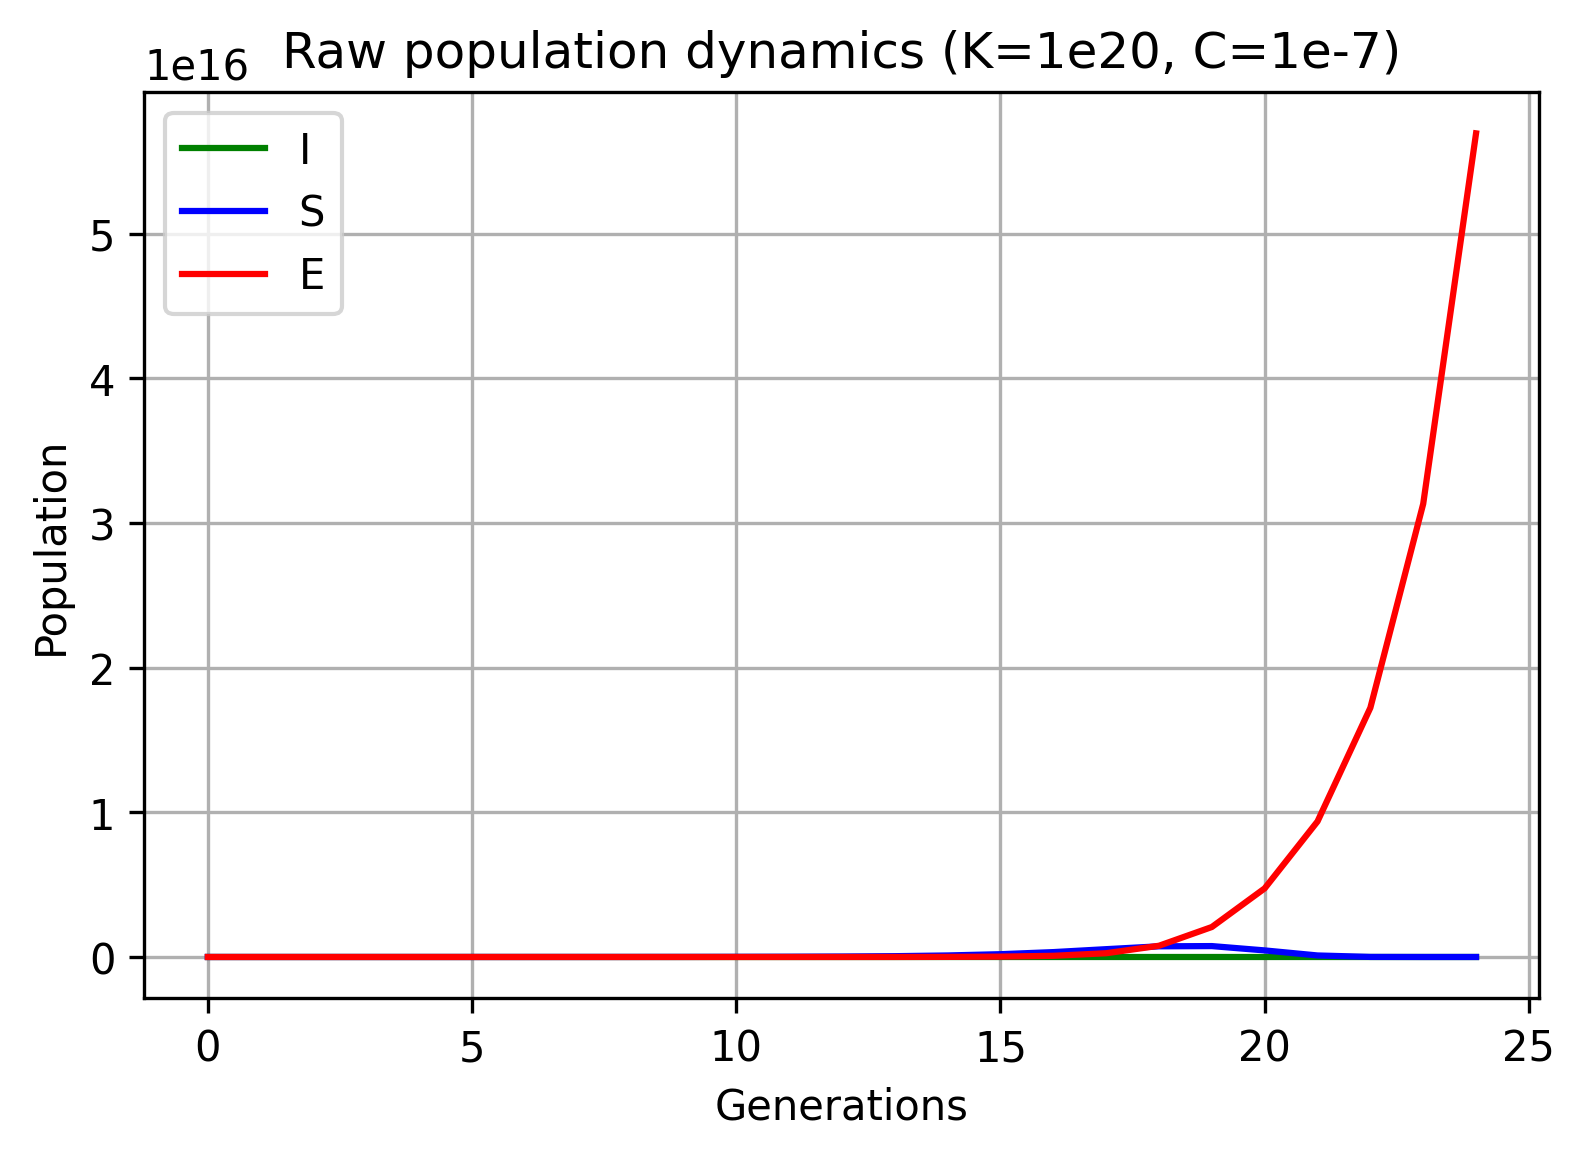

In [6]:
# Plot model (counts)

f1 = p.figure(dpi=300)
p.plot(t, I_out, 'g-', label = 'I')
p.plot(t, S_out, 'b-', label = 'S')
p.plot(t, E_out, 'r-', label = 'E')
p.grid()
p.legend(loc='best')
p.title('Raw population dynamics (K=1e20, C=1e-7)')
p.xlabel('Generations')
p.ylabel('Population')

fig_name = 'base_raw'
p.savefig(fig_name+'.png')

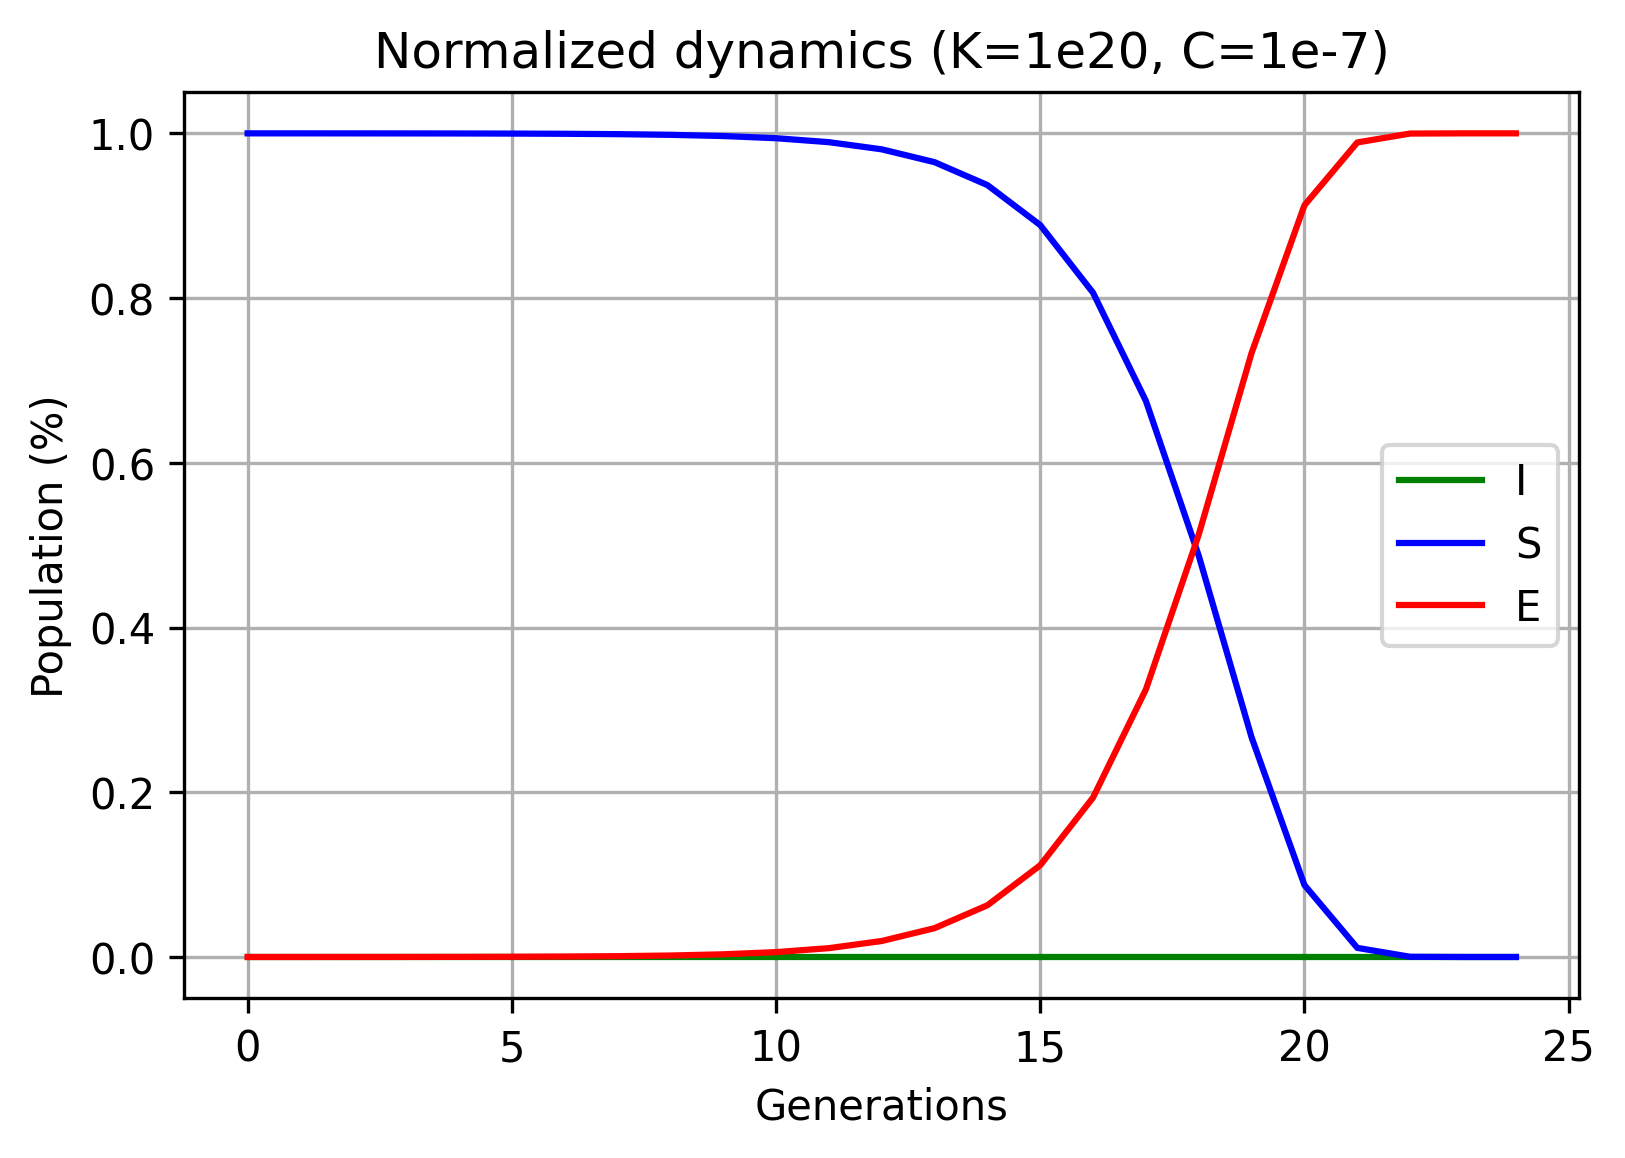

In [7]:
# Plot model (normalized)

f1 = p.figure(dpi=300)
N_out = I_out + S_out + E_out
p.plot(t, I_out/N_out, 'g-', label = 'I')
p.plot(t, S_out/N_out, 'b-', label = 'S')
p.plot(t, E_out/N_out, 'r-', label = 'E')
p.grid()
p.legend(loc='best')
p.title('Normalized dynamics (K=1e20, C=1e-7)')
p.xlabel('Generations')
p.ylabel('Population (%)')

fig_name = 'base_norm'
p.savefig(fig_name+'.png')

In [8]:
# Testing parameters across conjugation rate and carrying capacity

c_space = [1/10**_ for _ in range(16)]
c_rates = list(map(percent_change_to_rate, c_space))
C_rc = list(zip(c_rates, c_space))

def run_sim(K=False):
    inflection_points = []
    if not K:
        K=1
        include_carrying_capacity = False
    else:
        include_carrying_capacity = True

    def dX_dt(X, t=0):
        ''' ODEs. '''
        I_i, S_i, E_i = X
        N = sum(X) if include_carrying_capacity else 0           # incorporate carrying capacity
        return np.array([
            (B*I_i)*(1 - N/K) - (alpha*I_i),                     # d/dt(I)
            (B*S_i)*(1 - N/K) - (C*S_i*I_i) - (S_i*mu),          # d/dt(S)
            (C*S_i*I_i) + (B*E_i)*(1 - N/K) - (alpha*E_i)        # d/dt(E)
        ])
    
    for i, C_rc_i in enumerate(C_rc):
        C_rate, C_true = C_rc_i
        C = C_rate
        X, infodict = integrate.odeint(dX_dt, X0, t, full_output=True)      
        infl_point = find_inflection_point(X)
        inflection_points.append([C_rate, infl_point, C_true])

    return inflection_points


In [9]:
include_carrying_capacity = False
inflection_points_no_k = run_sim()
inf_point_list_no_k = [_[1] for _ in inflection_points_no_k]

C_rate_list = [_[0] for _ in inflection_points_no_k]
C_rate_list_log = list(map(np.log10, c_space))
C_rate_list_log_neg = [-1*tmp for tmp in C_rate_list_log]
percent_change = [_[2] for _ in inflection_points_no_k]       # true conjugation precent change

In [10]:
include_carrying_capacity = True
K = 1e15
inflection_points_k_1e15 = run_sim(K)
inf_point_list_k_1e15 = [_[1]+0.35 for _ in inflection_points_k_1e15]

In [11]:
include_carrying_capacity = True
K = 1e20
inflection_points_k_1e20 = run_sim(K)
inf_point_list_k_1e20 = [_[1]+0.2 for _ in inflection_points_k_1e20]

In [12]:
include_carrying_capacity = True
K = 1e30
inflection_points_k_1e30 = run_sim(K)
inf_point_list_k_1e30 = [_[1]-0.15 for _ in inflection_points_k_1e30]

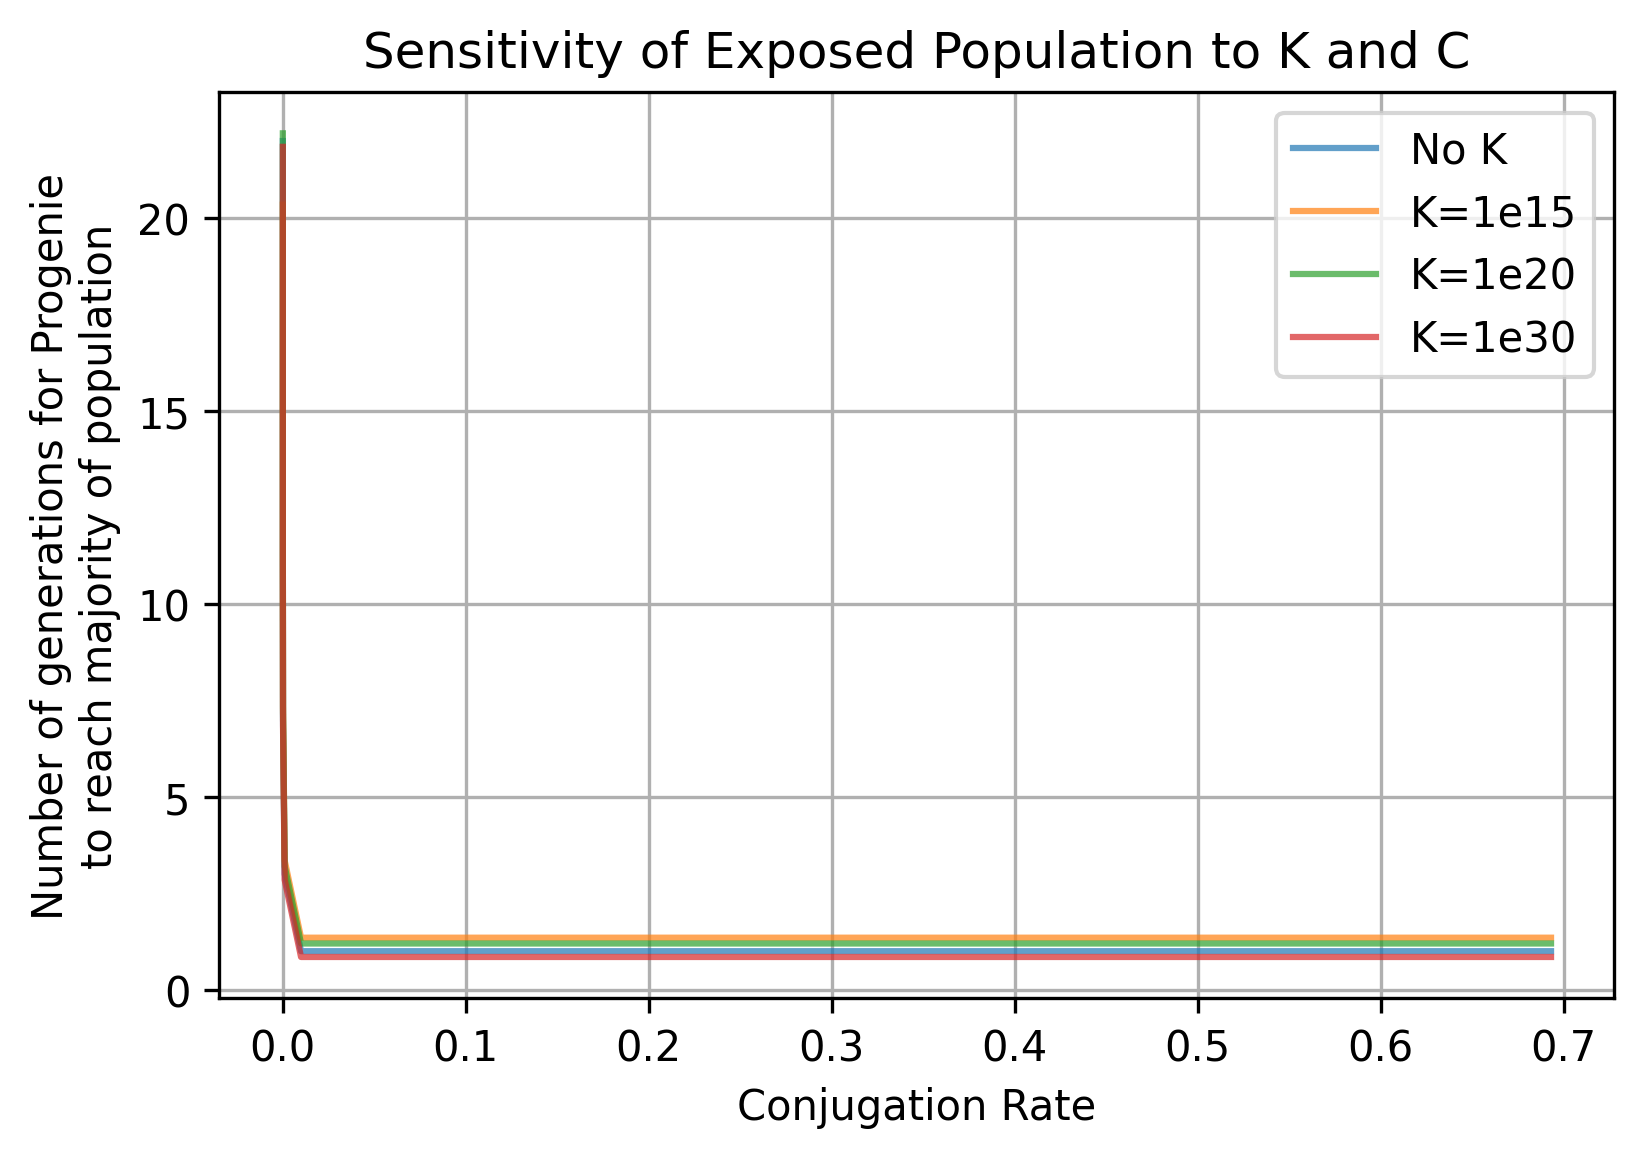

In [13]:
f1 = p.figure(dpi=300)
p.plot(C_rate_list, inf_point_list_no_k, '-', label = 'No K', alpha=0.7)
p.plot(C_rate_list, inf_point_list_k_1e15, '-', label = 'K=1e15', alpha=0.7)
p.plot(C_rate_list, inf_point_list_k_1e20, '-', label = 'K=1e20', alpha=0.7)
p.plot(C_rate_list, inf_point_list_k_1e30, '-', label = 'K=1e30', alpha=0.7)

p.grid()
p.legend(loc='best')
p.title('Sensitivity of Exposed Population to K and C')
p.xlabel('Conjugation Rate')
p.ylabel('Number of generations for Progenie\nto reach majority of population')

fig_name = 'sensitivity_raw'
p.savefig(fig_name+'.png')

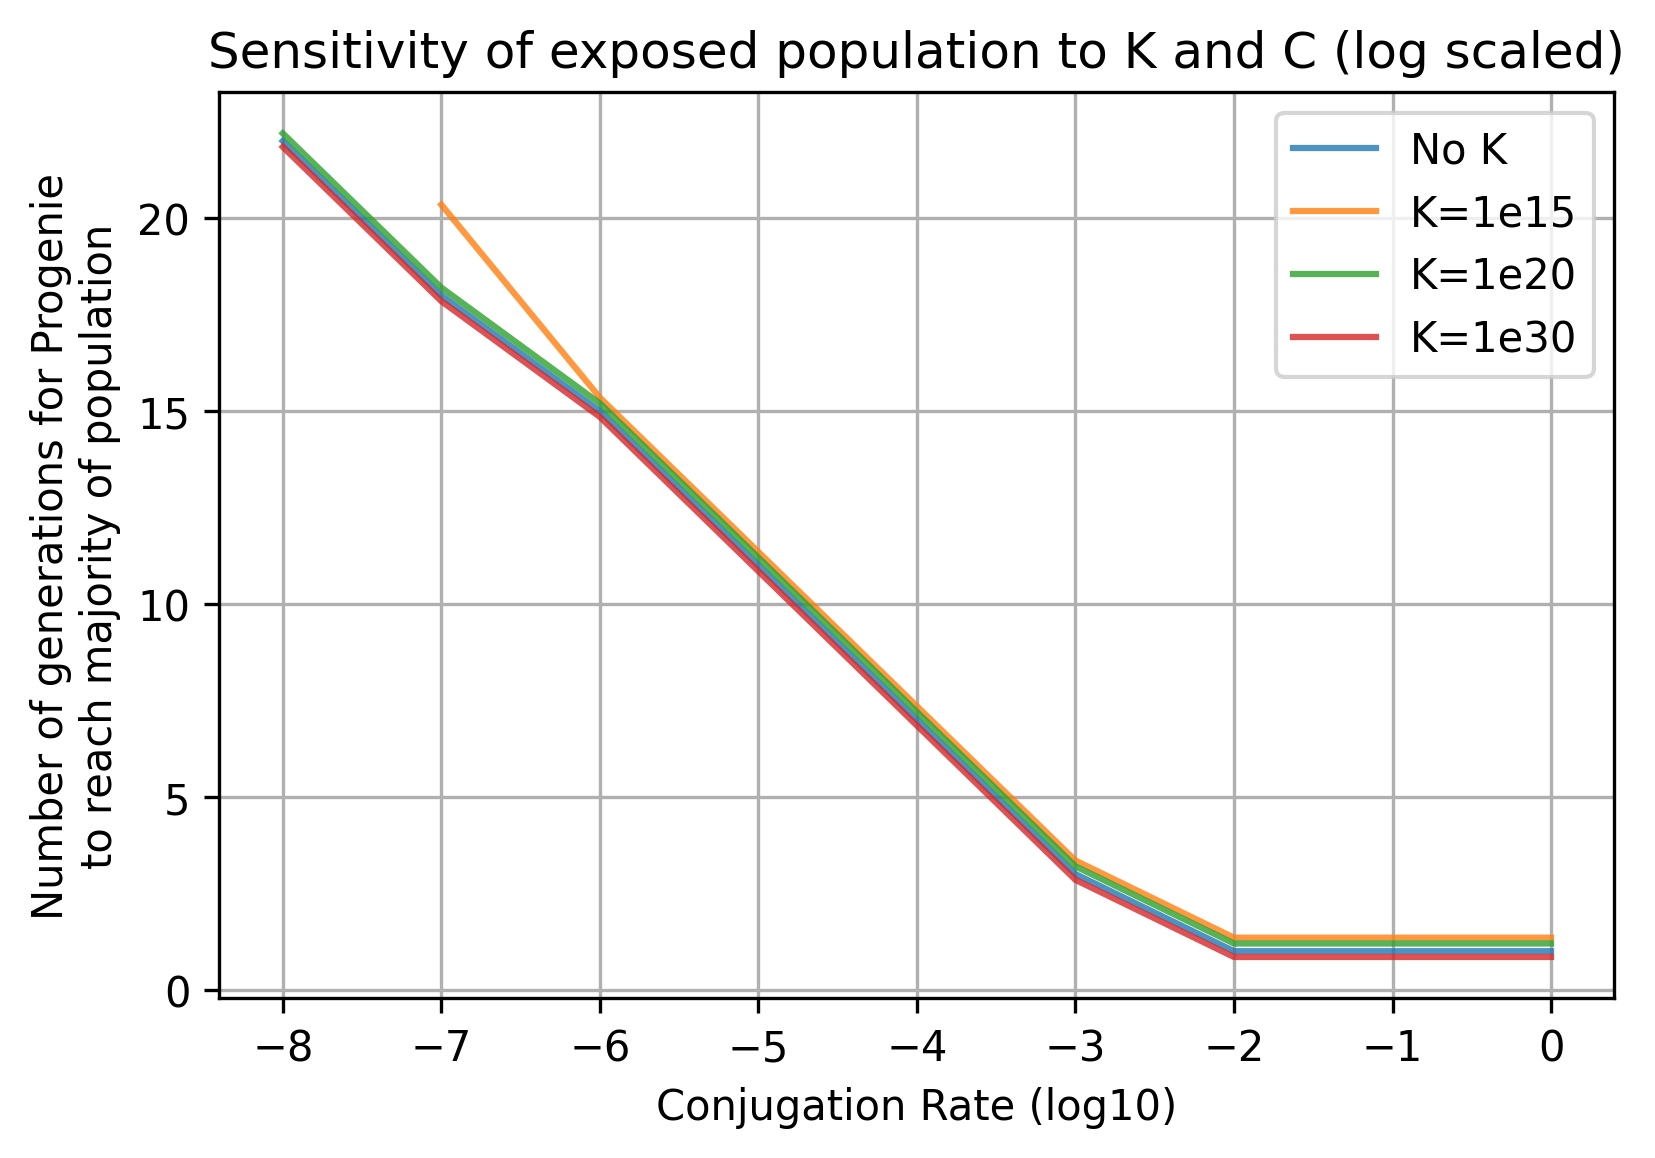

In [14]:
f1 = p.figure(dpi=300)

p.plot(C_rate_list_log, inf_point_list_no_k, '-', label = 'No K',alpha=0.8)
p.plot(C_rate_list_log, inf_point_list_k_1e15, '-', label = 'K=1e15',alpha=0.8)
p.plot(C_rate_list_log, inf_point_list_k_1e20, '-', label = 'K=1e20',alpha=0.8)
p.plot(C_rate_list_log, inf_point_list_k_1e30, '-', label = 'K=1e30',alpha=0.8)

p.grid()
p.legend(loc='best')

p.title('Sensitivity of exposed population to K and C (log scaled)')
p.xlabel('Conjugation Rate (log10)')
p.ylabel('Number of generations for Progenie\nto reach majority of population')

fig_name = 'sensitivity_log'
p.savefig(fig_name+'.png')